In [14]:
from pyspark.sql import Row
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, avg, col, count
from pyspark.sql.functions import concat
from pyspark.sql.functions import asc, desc, col, regexp_replace
import pandas as pd
import matplotlib.pyplot as plt



spark = SparkSession.builder.getOrCreate()

table1 = spark.read.format("csv").option("header", "true").load("./Raw Data/IMDBMovies.csv")
table1.show()

+----+--------------------+----+------+--------------------+-----------+--------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|rank|                name|year|rating|               genre|certificate|run_time|             tagline|              budget|box_office|               casts|           directors|             writers|
+----+--------------------+----+------+--------------------+-----------+--------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|   1|The Shawshank Red...|1994|   9.3|               Drama|          R|  2h 22m|Fear can hold you...|            25000000|  28884504|Tim Robbins,Morga...|      Frank Darabont|Stephen King,Fran...|
|   2|       The Godfather|1972|   9.2|         Crime,Drama|          R|  2h 55m|An offer you can'...|             6000000| 250341816|Marlon Brando,Al ...|Francis Ford Coppola|Mario Puzo,Franci...|
|   3|    

In [15]:
# Set column width to display the entire contents of the "casts" column
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", "500")
spark.conf.set("spark.sql.repl.eagerEval.truncate", "500")

Query1 = table1.select("rank", "name", "year", "rating", "genre", "certificate", "run_time", "tagline", "box_office", "casts") \
                .withColumn("box_office", regexp_replace(col("box_office"), "[^0-9]", "")) \
                .filter(col("box_office") != "") \
                .filter(col("box_office").rlike("^[0-9]+$")) \
                .orderBy(desc("box_office"))
Query1.show()

+----+--------------------+----+------+--------------------+-----------+--------+--------------------+----------+--------------------+
|rank|                name|year|rating|               genre|certificate|run_time|             tagline|box_office|               casts|
+----+--------------------+----+------+--------------------+-----------+--------+--------------------+----------+--------------------+
| 214|           Spotlight|2015|   8.1|Biography,Crime,D...|          R|   2h 9m|Break the story. ...|  98690254|Mark Ruffalo,Mich...|
|  62|  The Great Dictator|1940|   8.4|    Comedy,Drama,War|          G|   2h 5m|The Comedy Master...|    970263|Charles Chaplin,P...|
| 218|                Rush|2013|   8.1|Action,Biography,...|          R|   2h 3m|Everyone's driven...|  96983009|Daniel Brühl,Chri...|
|  36|       The Lion King|1994|   8.5|Animation,Adventu...|          G|  1h 28m|See it for the fi...| 968511805|Matthew Broderick...|
| 100|               Ikiru|1952|   8.3|               D

In [23]:
# To answer the question of do the actors affect the Box office amount
# no, it does not appear that the more famous an actor is, has no effect on a movie
# to pull a larger box office amount.
cleaned_table1 = table1.withColumn("box_office", regexp_replace("box_office", "[^0-9]", ""))
cleaned_table1.show()

+----+--------------------+----+------+--------------------+-----------+--------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|rank|                name|year|rating|               genre|certificate|run_time|             tagline|              budget|box_office|               casts|           directors|             writers|
+----+--------------------+----+------+--------------------+-----------+--------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|   1|The Shawshank Red...|1994|   9.3|               Drama|          R|  2h 22m|Fear can hold you...|            25000000|  28884504|Tim Robbins,Morga...|      Frank Darabont|Stephen King,Fran...|
|   2|       The Godfather|1972|   9.2|         Crime,Drama|          R|  2h 55m|An offer you can'...|             6000000| 250341816|Marlon Brando,Al ...|Francis Ford Coppola|Mario Puzo,Franci...|
|   3|    

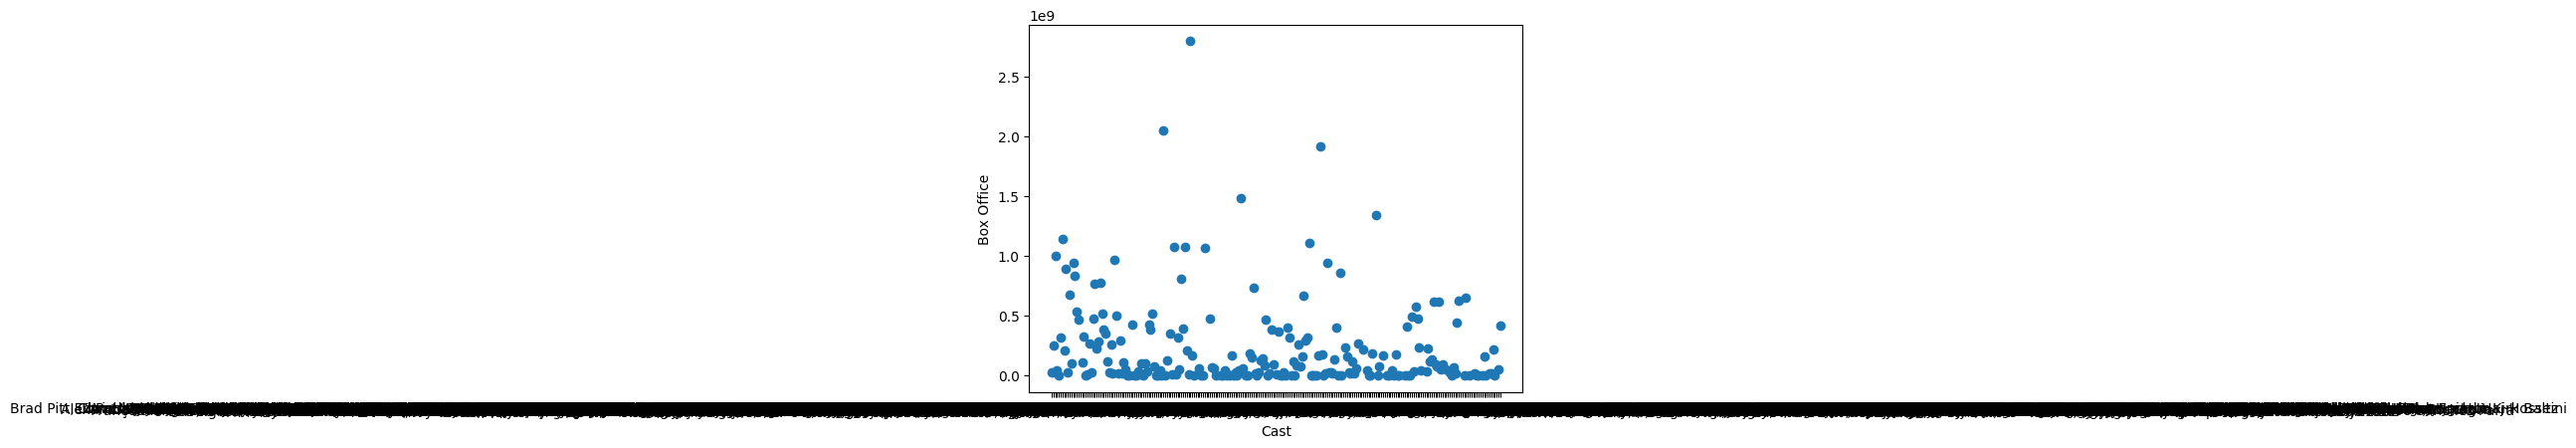

In [39]:
# Select the relevant columns from the table
cast_boxoffice = cleaned_table1.select("casts", "box_office").toPandas()

# Convert the box office column to numeric values
cast_boxoffice["box_office"] = pd.to_numeric(cast_boxoffice["box_office"])

# Create a scatter plot
plt.scatter(cast_boxoffice["casts"], cast_boxoffice["box_office"])
plt.xlabel("Cast")
plt.ylabel("Box Office")
plt.show()

In [40]:
Query2 = cleaned_table1.select("certificate", "box_office", "name", "year", "rating", "genre", "run_time", "tagline", "casts", "directors", "writers") \
                .withColumn("box_office", regexp_replace(col("box_office"), "[^0-9]", "")) \
                .filter(col("box_office") != "") \
                .filter(col("box_office").rlike("^[0-9]+$")) \
                .filter(col("certificate") != "") \
                .filter(col("certificate") != "Not Rated") \
                .orderBy(desc("box_office"))
Query2.show()


+-----------+----------+--------------------+----+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+
|certificate|box_office|                name|year|rating|               genre|run_time|             tagline|               casts|           directors|             writers|
+-----------+----------+--------------------+----+------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+
|          R|  98690254|           Spotlight|2015|   8.1|Biography,Crime,D...|   2h 9m|Break the story. ...|Mark Ruffalo,Mich...|        Tom McCarthy|Josh Singer,Tom M...|
|          G|    970263|  The Great Dictator|1940|   8.4|    Comedy,Drama,War|   2h 5m|The Comedy Master...|Charles Chaplin,P...|     Charles Chaplin|     Charles Chaplin|
|          R|  96983009|                Rush|2013|   8.1|Action,Biography,...|   2h 3m|Everyone's driven...|Daniel Brühl,Chri...|          R

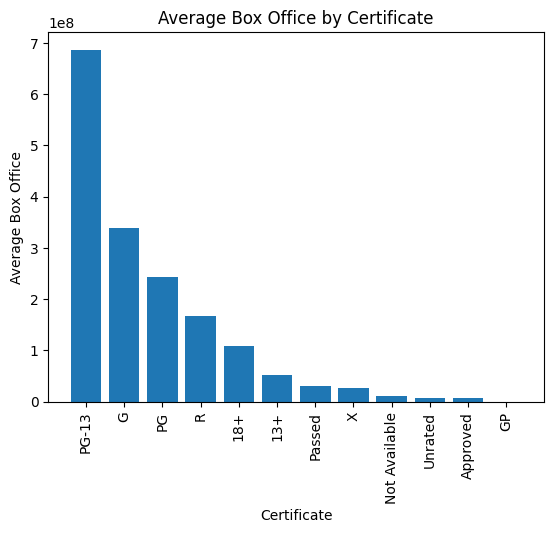

In [38]:
# Group the data by certificate and calculate the average box office value for each group
grouped_data = Query2.groupBy("certificate").agg({"box_office": "avg"}).orderBy(desc("avg(box_office)"))

# Convert the grouped data to a Pandas DataFrame for plotting
plot_data = grouped_data.toPandas()

# Create a bar chart of the average box office values by certificate
plt.bar(plot_data["certificate"], plot_data["avg(box_office)"])
plt.xticks(rotation=90)
plt.xlabel("Certificate")
plt.ylabel("Average Box Office")
plt.title("Average Box Office by Certificate")
plt.show()

In [ ]:
# To answer the question of do prior ratings affect the Box office amount?
# yes,, it appears that if a movie is rated PG-13, before it hits box office
# that it will leads to a movie pulling an almost-double box-office amount.